# Visualizing Itô process

Here, we will keep it to the basics, and instead we will just model a mean-reverting Ornstein–Uhlenbeck process given by
\begin{equation*}
dX_t = \theta(\mu-X_t)dt + \sigma_tdW_t,
\end{equation*}
where $\mu$ is a stationary mean, and, for simplicity, we will also consider $\sigma_t$ to not vary with time.

100%|██████████| 5/5 [00:00<00:00, 37.30it/s]


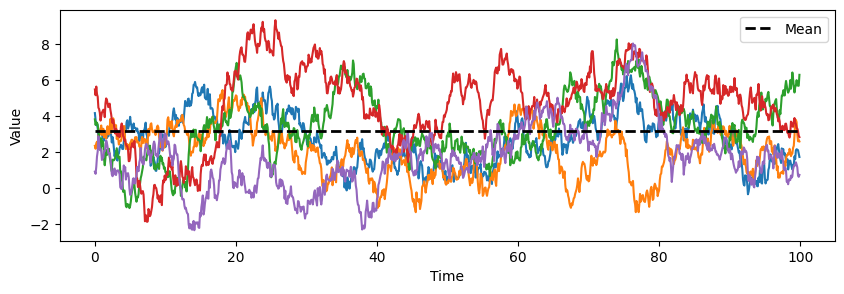

In [1]:
from typing import Union

import numpy as np
from tqdm import tqdm

from quant_learn.utils.funcs import ConstantFunction
from quant_learn.stochastic_processes.ito import ItoProcess as Ito

# Define drift
class OUDrift():
    def __init__(self,
                 mean: Union[float, np.ndarray],
                 scale: Union[float, np.ndarray]) -> None:
        self.mean = mean
        self.scale = scale
    
    def __call__(self, time: float, x: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
        mu = self.mean
        theta = self.scale
        return theta * (mu - x)
    
# Choose parameters
mean = 3.14159
scale = 0.1
drift = OUDrift(mean=mean, scale=scale)
diffusion = ConstantFunction(constant=1.0)
rng_seed = 27182818284

ou_proc = Ito(infinitesimal_time_interval=0.1,
              drift=drift,
              stochastic_stepper=diffusion,
              seed=rng_seed
              )

# Simulate being off from the mean
num_simulations = 5
num_steps = 1000
for _ in tqdm(range(num_simulations)):
    start_val = np.random.uniform(low=0, high=6)
    timestamps, values = ou_proc.simulate(num_steps=num_steps, start_value=start_val)

fig, axes = ou_proc.plot_runs(figsize=(10, 3))
axes.plot([timestamps[0], timestamps[-1]], [mean, mean],
          'k--', linewidth=2, label='Mean')
_ = axes.legend()

We can also simulate a geometric Brownian motion, given by
\begin{equation*}
dX_t = \mu X_t dt + \sigma X_t dW_t
\end{equation*}

The solution to this equation has the form
\begin{equation*}
X_t = X_0 \exp\left[\left(\mu -\frac{\sigma^2}{2} \right)dt + \sigma W_t\right]
\end{equation*}


100%|██████████| 10000/10000 [00:26<00:00, 376.05it/s]


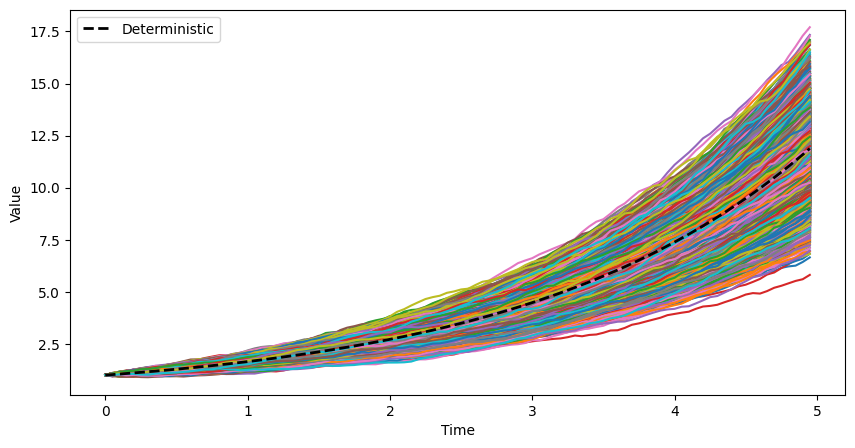

In [2]:
class SimpleScale():
    def __init__(self, scale: Union[float, np.ndarray]):
        self.scale = scale

    def __call__(self, time: float, x: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
        return self.scale * x
    
# Define parameters
mu = 0.5
sigma2 = 0.01  # NOTE: this is not actually the same sigma, as it provides the covariance!
drift = SimpleScale(scale=mu)
diffusion = SimpleScale(scale=sigma2)
rng_seed = 62831

gbm = Ito(infinitesimal_time_interval=0.05,
          drift=drift,
          stochastic_stepper=diffusion,
          seed=rng_seed)

# Simulate
num_simulations = 10000
num_steps = 100
for _ in tqdm(range(num_simulations)):
    timestamps, values = gbm.simulate(num_steps=num_steps, start_value=1.)

# Plot
fig, axes = gbm.plot_runs(figsize=(10, 5))
# Let's also plot the "deterministic" part of the solution to the stochastic differential equation above
deterministic_sol = np.exp((mu - (sigma2 * sigma2 / 2.)) * timestamps)
axes.plot(timestamps, deterministic_sol,
          'k--', linewidth=2, label='Deterministic')
_ = axes.legend(loc='upper left')

At each timestamp, we should expect the ratio between the geometric Brownian motion paths and the deterministic "mean" to be log-normal distributed. I am not going to do a full hypothesis test here, but I will plot these values for ocular inspection.

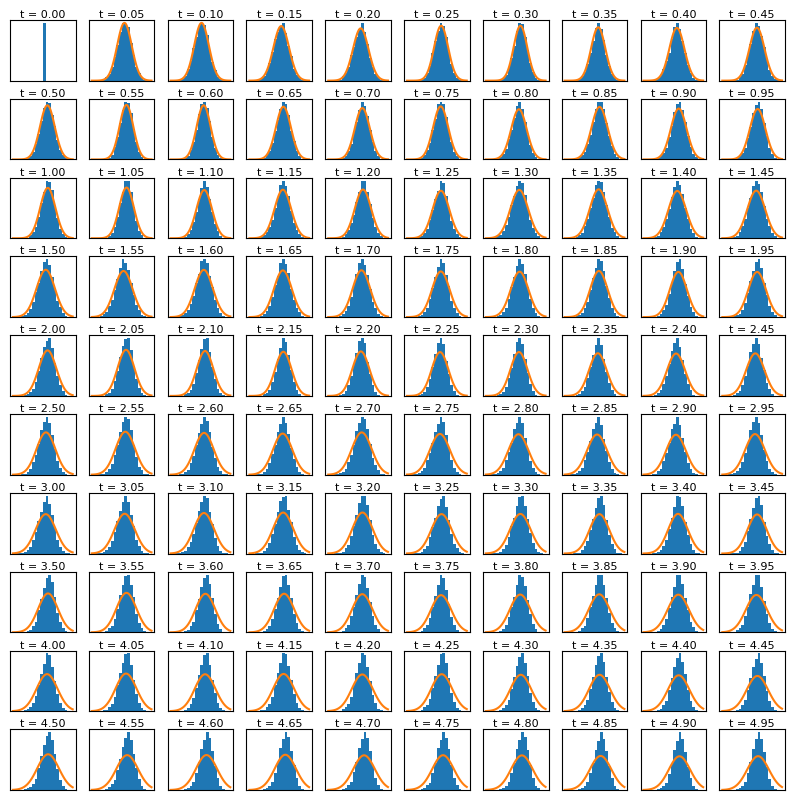

In [3]:
import matplotlib.pyplot as plt

ratios = np.log(np.array([vals / deterministic_sol for _, vals in gbm.simulation_history]))

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
# fig.tight_layout()
fig.subplots_adjust(hspace=0.3)

for i in range(10):
    for j in range(10):
        index = 10*i + j
        time = timestamps[index]
        var = time * sigma2
        mean = np.mean(ratios[:, index])
        axes[i,j].hist(ratios[:, index], bins=20, density=True)
        # plot a Gaussian PDF
        if time > 0:
            x_lims = axes[i,j].get_xlim()
            x_vals = np.linspace(x_lims[0], x_lims[1], 100)
            pdf = 1./(np.sqrt(2 * np.pi * var)) * np.exp(-(x_vals - mean)**2 / (2 * var))
            axes[i,j].plot(x_vals, pdf)

        # Clean up
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
        axes[i,j].set_title(f't = {time:.2f}', fontsize=8, y=0.9)

It seems the "normality" of these ratios goes down the further along we go, but that could be explained by there just not being enough samples to fully explore the distribution space that far from the starting time.